# ELECTRA Sentence Embeddings with NLU 

A text encoder trained to distinguish real input tokens from plausible fakes efficiently learns effective language representations.

### Sources :
- https://arxiv.org/abs/2003.10555

### Paper abstract :

Masked language modeling (MLM) pre-training methods such as BERT corrupt the input by replacing some tokens with [MASK] and then train a model to reconstruct the original tokens. While they produce good results when transferred to downstream NLP tasks, they generally require large amounts of compute to be effective. As an alternative, we propose a more sample-efficient pre-training task called replaced token detection. Instead of masking the input, our approach corrupts it by replacing some tokens with plausible alternatives sampled from a small generator network. Then, instead of training a model that predicts the original identities of the corrupted tokens, we train a discriminative model that predicts whether each token in the corrupted input was replaced by a generator sample or not. Thorough experiments demonstrate this new pre-training task is more efficient than MLM because the task is defined over all input tokens rather than just the small subset that was masked out. As a result, the contextual representations learned by our approach substantially outperform the ones learned by BERT given the same model size, data, and compute. The gains are particularly strong for small models; for example, we train a model on one GPU for 4 days that outperforms GPT (trained using 30x more compute) on the GLUE natural language understanding benchmark. Our approach also works well at scale, where it performs comparably to RoBERTa and XLNet while using less than 1/4 of their compute and outperforms them when using the same amount of compute.


# 1. Install Java and NLU

In [10]:

import os
! apt-get update -qq > /dev/null   
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! pip install nlu  > /dev/null    



## 2. Load  Model and embed sample sentence with ELECTRA Sentence Embedder

In [11]:
import nlu
pipe = nlu.load('embed_sentence.electra')
pipe.predict('He was suprised by the diversity of NLU')

sent_electra_small_uncased download started this may take some time.
Approximate size to download 48.7 MB
[OK!]


,sentence,embed_sentence_electra_embeddings
origin_index,,
0,He was suprised by the diversity of NLU,"[0.005376118700951338, 0.18036000430583954, -0..."


# 3. Download Sample dataset

In [12]:
import pandas as pd
# Download the dataset 
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv -P /tmp
# Load dataset to Pandas
df = pd.read_csv('/tmp/train-balanced-sarcasm.csv')
df

--2020-10-07 07:46:42--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.45.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.45.118|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘/tmp/train-balanced-sarcasm.csv’ not modified on server. Omitting download.



,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


# 4. Visualize Embeddings with T-SNE




Lets add Sentiment and Part Of Speech to our pipeline because its so easy and so we can hue our T-SNE plots by POS and Sentiment       


In [13]:
pipe = nlu.load('pos sentiment embed_sentence.electra') # emotion
df['text'] = df['comment']

# We must set output level to sentence since NLU will infer a different output level for this pipeline composition
predictions = pipe.predict(df[['text','label']].iloc[0:5000], output_level='sentence')
predictions

pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[OK!]
analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]
sent_electra_small_uncased download started this may take some time.
Approximate size to download 48.7 MB
[OK!]


,document_assembler@sentiment,checked,sentence_detector@sentiment,label,sentiment_confidence,pos,sentence,text,sentiment,embed_sentence_electra_embeddings
origin_index,,,,,,,,,,
0,[NC and NH.],"[NC, and, NH, .]",[NC and NH.],0,0.522900,"[NNP, CC, NNP, .]",NC and NH.,NC and NH.,negative,"[0.2315235584974289, -0.09077175706624985, -0...."
1,[You do know west teams play against west team...,"[You, do, know, west, teams, play, against, we...",[You do know west teams play against west team...,0,0.473300,"[PRP, VBP, VB, NN, NNS, VBP, IN, NN, NNS, JJR,...",You do know west teams play against west teams...,You do know west teams play against west teams...,negative,"[-0.05734064429998398, -0.08123745769262314, 0..."
2,"[They were underdogs earlier today, but since ...","[They, were, underdogs, earlier, today, ,, but...","[They were underdogs earlier today, but since ...",0,0.511800,"[PRP, VBD, NNS, RBR, NN, ,, CC, IN, NNP, NN, D...","They were underdogs earlier today, but since G...","They were underdogs earlier today, but since G...",negative,"[0.08615931123495102, -0.026166768744587898, -..."
3,"[This meme isn't funny none of the ""new york n...","[This, meme, isn't, funny, none, of, the, "", n...","[This meme isn't funny none of the ""new york n...",0,0.515500,"[DT, NN, NN, JJ, NN, IN, DT, '', JJ, NNP, NN, ...","This meme isn't funny none of the ""new york ni...","This meme isn't funny none of the ""new york ni...",negative,"[-0.0065225474536418915, 0.030370917171239853,..."
4,[I could use one of those tools.],"[I, could, use, one, of, those, tools, .]",[I could use one of those tools.],0,0.474500,"[PRP, MD, VB, CD, IN, DT, NNS, .]",I could use one of those tools.,I could use one of those tools.,negative,"[0.009141731075942516, 0.6086332201957703, -0...."
...,...,...,...,...,...,...,...,...,...,...
4995,[It's really hard to be positive about Blash a...,"[it's, really, hard, to, be, positive, about, ...",[It's really hard to be positive about Blash a...,0,0.528700,"[NNP, RB, JJ, TO, VB, JJ, IN, NNP, IN, DT, NN, .]",It's really hard to be positive about Blash at...,It's really hard to be positive about Blash at...,negative,"[-0.2417130172252655, 0.015201414003968239, -0..."
4996,"[Thats what I was thinking, they're just stall...","[chats, what, I, was, thinking, ,, they're, ju...","[Thats what I was thinking, they're just stall...",0,0.491200,"[NNP, WP, PRP, VBD, VBG, ,, NN, RB, VBG]","Thats what I was thinking, they're just stalling","Thats what I was thinking, they're just stalling",negative,"[-0.33253201842308044, 0.02796638384461403, 0...."
4997,[Pretty good art but no glasses on the Mei mak...,"[Pretty, good, art, but, no, glasses, on, the,...",[Pretty good art but no glasses on the Mei mak...,0,0.468000,"[NNP, JJ, NN, CC, DT, NNS, IN, DT, NNP, VBZ, P...",Pretty good art but no glasses on the Mei make...,Pretty good art but no glasses on the Mei make...,positive,"[-0.21969836950302124, 0.3534011244773865, -0...."


## 4.1 Checkout sentiment distribution

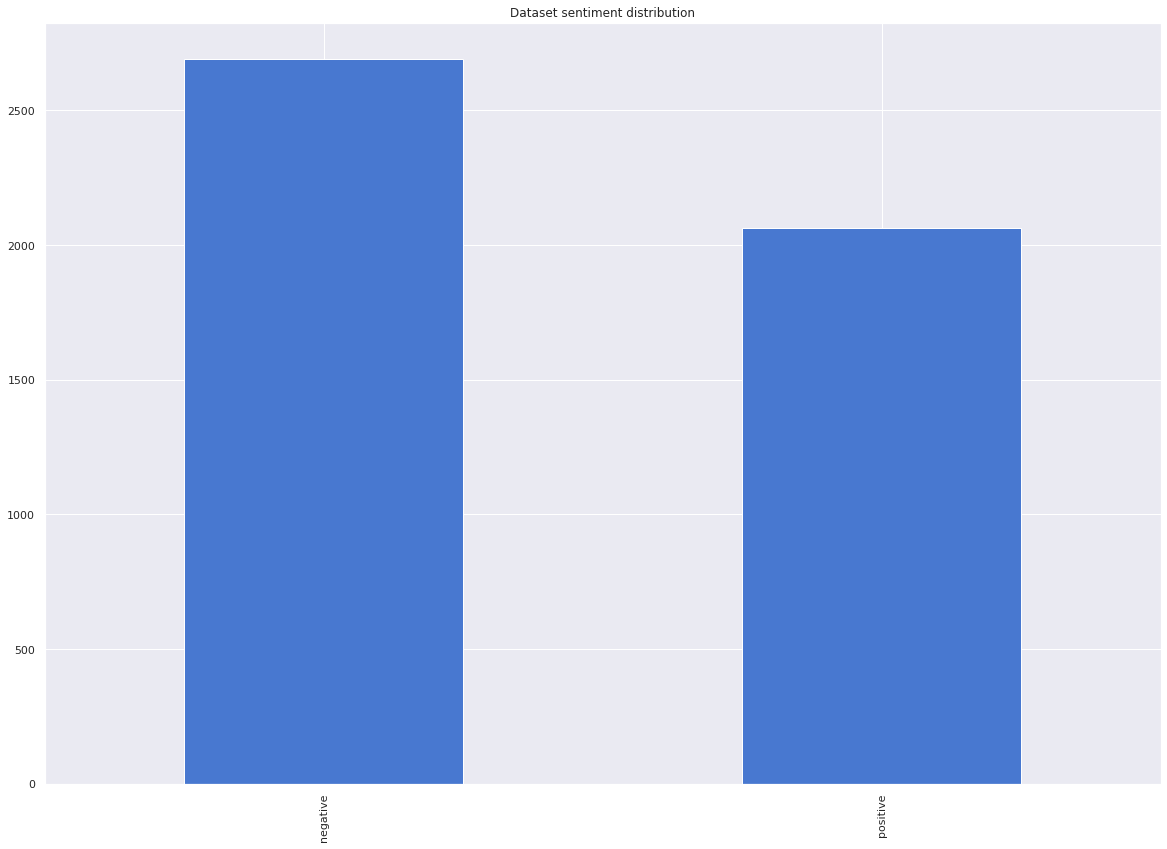

In [14]:
# Some Tokens are None which we must drop first
predictions.dropna(how='any', inplace=True)
# Some sentiment are 'na' which we must drop first
predictions = predictions[predictions.sentiment!= 'na']
predictions.sentiment.value_counts().plot.bar(title='Dataset sentiment distribution')

# 5.Prepare data for T-SNE algorithm.
We create a Matrix with one row per Embedding vector for T-SNE algorithm

In [15]:
import numpy as np


# Make a matrix from the vectors in the np_array column via list comprehension
mat = np.matrix([x for x in predictions.embed_sentence_electra_embeddings])

## 5.1 Fit and transform T-SNE algorithm


In [16]:

from sklearn.manifold import TSNE
model = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (4756, 2)


### Set plotting styles

In [17]:
# set some styles for for Plotting
import seaborn as sns
# Style Plots a bit
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1,rc={"lines.linewidth": 2.5})

%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (20, 14)


##5.2 Plot low dimensional T-SNE ELECTRA Sentence embeddings with hue for Sarcasm


In [18]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.label.replace({1:'sarcasm',0:'normal'}))
tsne_df.columns = ['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE ELECTRA Sentence Embeddings, colored by Sarcasm label')


TypeError: ignored

## 5.3 Plot low dimensional T-SNE ELECTRA Sentence embeddings with hue for Sentiment


Text(0.5, 1.0, 'T-SNE ELECTRA Sentence Embeddings, colored by Sentiment')

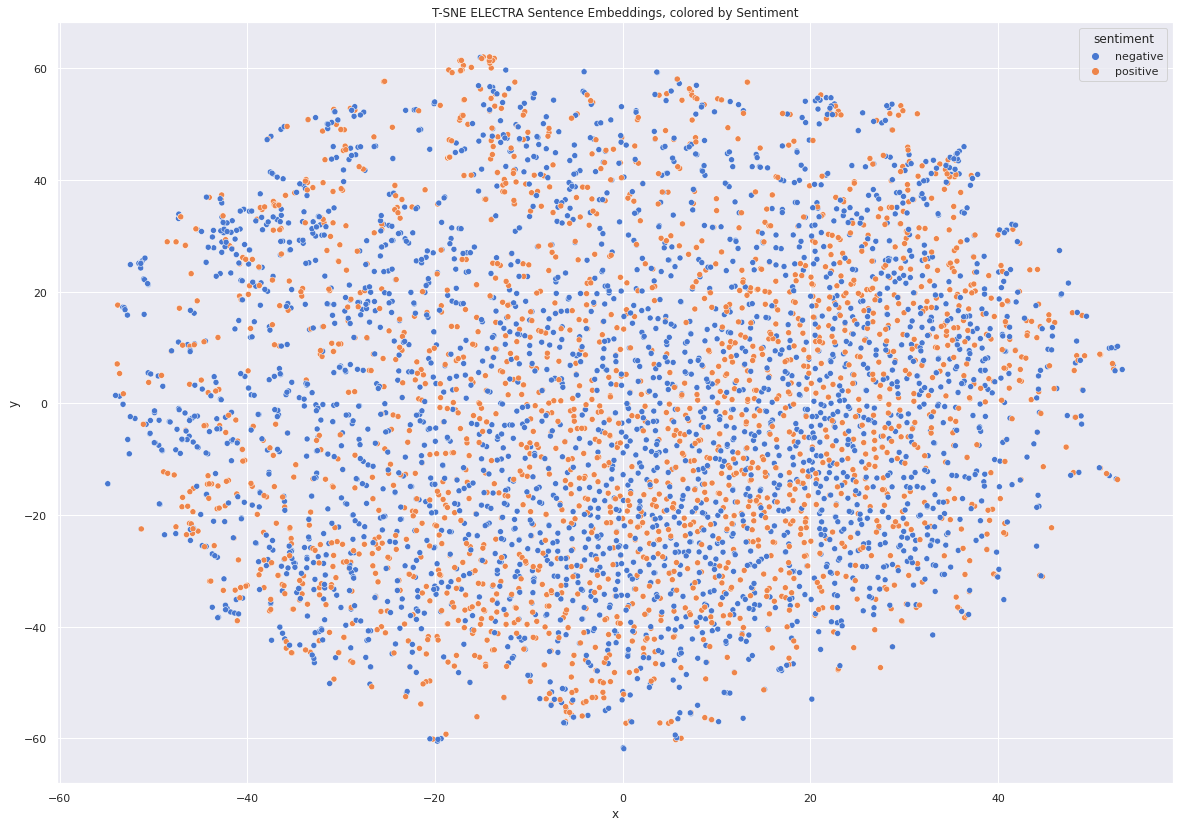

In [19]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.sentiment)
tsne_df.columns = ['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE ELECTRA Sentence Embeddings, colored by Sentiment')


# 6.1 Plot low dimensional T-SNE USE embeddings with hue for POS     
Because we will have a list of pos labels for each sentence, we need to explode on the pos column and then do the data peperation for T-SNE again before we can visualize with hue for POS


In [20]:
predictions_exploded_on_pos = predictions.explode('pos')
predictions_exploded_on_pos

,document_assembler@sentiment,checked,sentence_detector@sentiment,label,sentiment_confidence,pos,sentence,text,sentiment,embed_sentence_electra_embeddings
origin_index,,,,,,,,,,
0,[NC and NH.],"[NC, and, NH, .]",[NC and NH.],0,0.522900,NNP,NC and NH.,NC and NH.,negative,"[0.2315235584974289, -0.09077175706624985, -0...."
0,[NC and NH.],"[NC, and, NH, .]",[NC and NH.],0,0.522900,CC,NC and NH.,NC and NH.,negative,"[0.2315235584974289, -0.09077175706624985, -0...."
0,[NC and NH.],"[NC, and, NH, .]",[NC and NH.],0,0.522900,NNP,NC and NH.,NC and NH.,negative,"[0.2315235584974289, -0.09077175706624985, -0...."
0,[NC and NH.],"[NC, and, NH, .]",[NC and NH.],0,0.522900,.,NC and NH.,NC and NH.,negative,"[0.2315235584974289, -0.09077175706624985, -0...."
1,[You do know west teams play against west team...,"[You, do, know, west, teams, play, against, we...",[You do know west teams play against west team...,0,0.473300,PRP,You do know west teams play against west teams...,You do know west teams play against west teams...,negative,"[-0.05734064429998398, -0.08123745769262314, 0..."
...,...,...,...,...,...,...,...,...,...,...
4999,[Then cut half the roster.],"[Then, cut, half, the, roster, .]",[Then cut half the roster.],0,0.467100,VB,Then cut half the roster.,Then cut half the roster.,negative,"[0.19212713837623596, 0.13184911012649536, -0...."
4999,[Then cut half the roster.],"[Then, cut, half, the, roster, .]",[Then cut half the roster.],0,0.467100,NN,Then cut half the roster.,Then cut half the roster.,negative,"[0.19212713837623596, 0.13184911012649536, -0...."
4999,[Then cut half the roster.],"[Then, cut, half, the, roster, .]",[Then cut half the roster.],0,0.467100,DT,Then cut half the roster.,Then cut half the roster.,negative,"[0.19212713837623596, 0.13184911012649536, -0...."


## 6.2 Preprocess data for TSNE again

In [21]:
# Make a matrix from the vectors in the np_array column via list comprehension
mat = np.matrix([x for x in predictions_exploded_on_pos.embed_sentence_electra_embeddings])


from sklearn.manifold import TSNE
model = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (56317, 2)


# 6.3 Plot low dimensional T-SNE ELECTRA Sentence embeddings with hue for POS      


Text(0.5, 1.0, 'T-SNE ELECTRA Sentence Embeddings, colored by Part of Speech Tag')

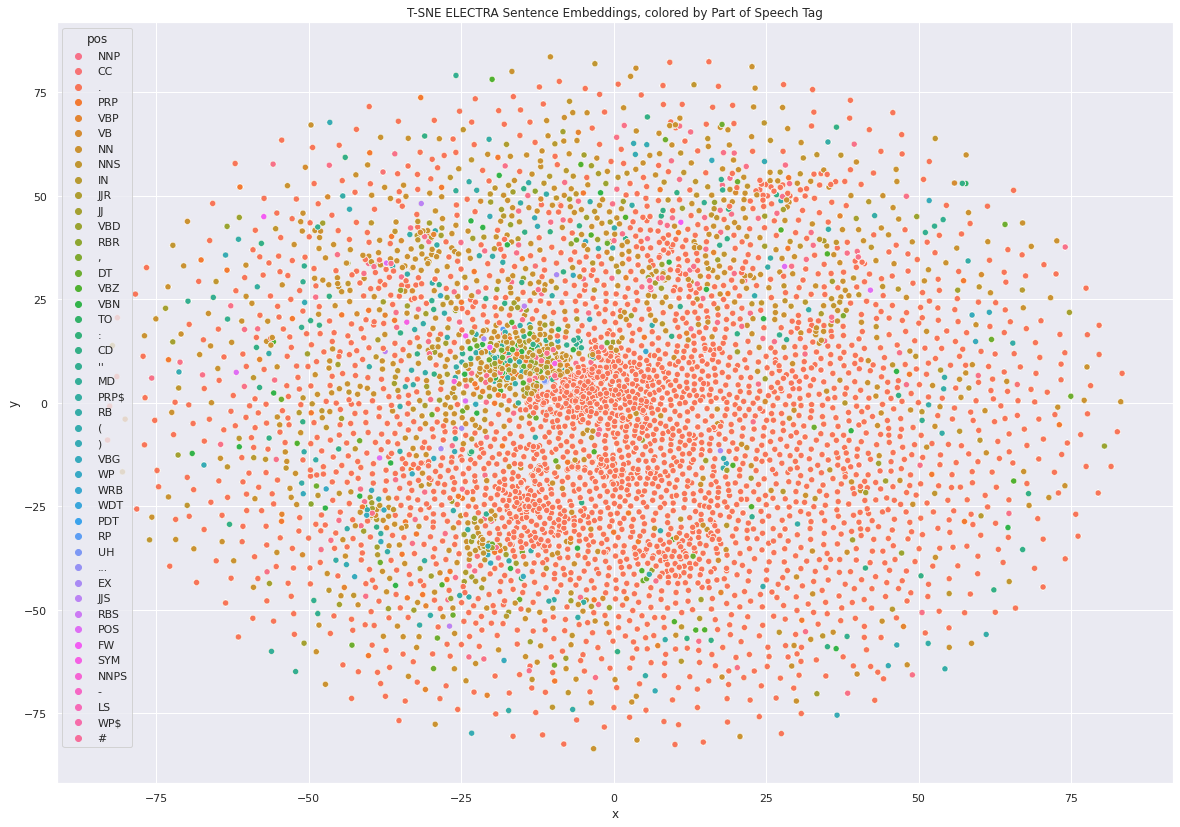

In [22]:
tsne_df =  pd.DataFrame(low_dim_data, predictions_exploded_on_pos.pos)
tsne_df.columns = ['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE ELECTRA Sentence Embeddings, colored by Part of Speech Tag')


# 7. NLU has many more sentence embedding models!      
Make sure to try them all out!       
You can change 'embed_sentence.electra' in nlu.load('embed_sentence.electra') to bert, xlnet, albert or any other of the **20+ sentence embeddings** offerd by NLU

In [23]:
nlu.print_all_model_kinds_for_action('embed_sentence')

For language <en> NLU provides the following Models : 
nlu.load('en.embed_sentence') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.use') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.tfhub_use') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.use.lg') returns Spark NLP model tfhub_use_lg
nlu.load('en.embed_sentence.tfhub_use.lg') returns Spark NLP model tfhub_use_lg
nlu.load('en.embed_sentence.albert') returns Spark NLP model albert_base_uncased
nlu.load('en.embed_sentence.electra') returns Spark NLP model sent_electra_small_uncased
nlu.load('en.embed_sentence.electra_small_uncased') returns Spark NLP model sent_electra_small_uncased
nlu.load('en.embed_sentence.electra_base_uncased') returns Spark NLP model sent_electra_base_uncased
nlu.load('en.embed_sentence.electra_large_uncased') returns Spark NLP model sent_electra_large_uncased
nlu.load('en.embed_sentence.bert') returns Spark NLP model sent_bert_base_uncased
nlu.load('en.embed_sentenc